In [5]:
%run base.ipynb

ERROR:root:File `'base.ipynb.py'` not found.


In [1]:
import matplotlib.pyplot as plt
import torch as t
import pandas as pd
import os
from utils.stopwatch import stopwatch

ModuleNotFoundError: No module named 'utils.stopwatch'

In [3]:
dataset_path='/projects/datasets/m4/'
metadata = pd.read_csv(os.path.join(dataset_path, 'original/M4Info.csv'), index_col=0)

metadata.head()

# training_dataset_dir = os.path.join(self.dataset_path, dset_type)
# files_list = os.listdir(training_dataset_dir)


,category,Frequency,Horizon,SP,StartingDate
M4id,,,,,
Y1,Macro,1,6,Yearly,1979-01-01 12:00:00
Y2,Macro,1,6,Yearly,1979-01-01 12:00:00
Y3,Macro,1,6,Yearly,1979-01-01 12:00:00
Y4,Macro,1,6,Yearly,1979-01-01 12:00:00
Y5,Macro,1,6,Yearly,1979-01-01 12:00:00


In [5]:
@utils.stopwatch.stopwatch
def load_data():
    dataset_path='/projects/datasets/m4/'
    dataset_path='/projects/datasets/m4_transfer_learning_test/'

    metadata = pd.read_csv(os.path.join(dataset_path, 'original/M4Info.csv'), index_col=0)
    training_dataset_dir = os.path.join(dataset_path, 'train')
    daily_dataset_path = os.path.join(training_dataset_dir, 'daily_train_01.csv')
    # daily_dataset_path = os.path.join(training_dataset_dir, 'Daily-train.csv')

    data_list = []
    frame = pd.read_csv(daily_dataset_path, index_col=0)
    
    for ts_id, ts_values in frame.iterrows():
        ts_meta = metadata.loc[ts_id]
        ts_metadata = {
            'M4id': ts_id,
            'category': ts_meta['category'],
            'period': ts_meta['Frequency'],
            'seasonality': ts_meta['SP'],
            'forecast_horizon': ts_meta['Horizon']
        }
        data_list.append(
            { 
                'meta': ts_metadata,
                'data': ts_values.dropna().to_frame().reset_index(drop=True)
            }
        )

    return data_list

data_list = load_data()


AttributeError: module 'utils' has no attribute 'stopwatch'

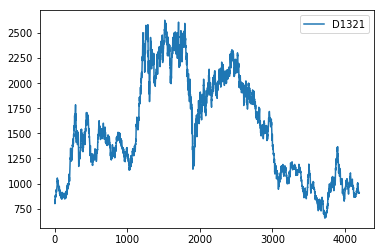

In [6]:
data_list[0]['data'].plot()
plt.show()

In [10]:
from typing import Tuple

class TSLSTM(t.nn.Module):
    def __init__(self, hidden_size, num_layers, optim, loss):
        super().__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.batch_size = 1
        self.optim = optim
        self.loss = loss
        self.training_losses = []
        
        self.lstm = t.nn.LSTM(input_size=1,
                              hidden_size=hidden_size,
                              num_layers=num_layers,
                              batch_first=True
                             )
        self.output_layer = t.nn.Linear(in_features=hidden_size, out_features=1)                          
        self.state = self.__init_state()
        
    def update(self, df: pd.DataFrame) -> None:
        # init
        x = df_to_tensor(df)
        optim = self.optim(self.parameters())
        self.__reset_state()
        # forward pass
        print(f"avant {x[:, :-1, :]}")
        prediction = self(x[:, :-1, :])
        print("apres")
        # calculate and store loss
        loss_fn = self.loss(prediction, x[:, 1:, :])
        self.training_losses.append(float(loss_fn))
        # backprop
        loss_fn.backward()
        optim.step()
    
    def predict(self, df: pd.DataFrame, forecast_horizon: int) -> pd.DataFrame:
        self.__reset_state()        
        prediction = self(df_to_tensor(df))
        insample = prediction[:, :-1, :]
        outsample = [prediction[:, -1:, :]]
        
        while len(outsample) <= forecast_horizon:
            outsample.append(self(outsample[-1]))
            
        insample_df = tensor_to_df(insample, df)
        result = insample_df.shift(1)
        for outsample_result in outsample:
            result = pd.concat([result, tensor_to_df(outsample_result, df)], axis=0, ignore_index=True)
        return result
    
    def forward(self, x):
        output, self.state = self.lstm(x, self.state)
        output = self.output_layer(output)
        return output        
    
    def __reset_state(self) -> None:
        self.state = self.__init_state()
    
    def __init_state(self) -> Tuple[t.Tensor, t.Tensor]:
        return (t.zeros(self.num_layers, self.batch_size, self.hidden_size),
                t.zeros(self.num_layers, self.batch_size, self.hidden_size))

In [11]:
naive = ('naive', Naive())
lstm = ('lstm', TSLSTM(hidden_size=100, 
                       num_layers=1,
                       optim=lambda p: t.optim.Adam(p, lr=1e-4),
                       loss=t.nn.L1Loss(reduction='elementwise_mean')))

# print(data_list[0]['meta'])
horizon = data_list[0]['meta']['forecast_horizon']
data = data_list[0]['data']
# print(type(data))

trainer = Trainer(
    models=dict([naive, lstm]), 
    history=data[:-horizon], future=data[-horizon:],     
    training_loss_fn=L1, test_loss_fn=L1)

In [12]:
for i in range(1):
    trainer.train()
    
    time_series = trainer.time_series
    
#     plt.figure(num=1)
#     plt.clf()
#     for ts_name in list(time_series.columns.levels[0]):
#         plt.plot(time_series[ts_name][:-horizon], label=ts_name)
#     plt.legend()
#     plt.gcf().canvas.draw()
    
#     plt.figure(num=2)
#     plt.clf()
#     for ts_name in list(time_series.columns.levels[0]):
#         plt.plot(time_series[ts_name][-horizon:], label=ts_name)
#     plt.legend()
#     plt.gcf().canvas.draw()

avant tensor([[[ 801.5300],
         [ 816.3700],
         [ 801.4700],
         ...,
         [ 988.5300],
         [ 978.6400],
         [ 963.7400]]], device='cuda:0')


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().


RuntimeError: param_from.type() == param_to.type() ASSERT FAILED at /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:491, please report a bug to PyTorch. parameter types mismatch